In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wide_df = pd.read_csv('input_csvs/qpcr_data_wide.csv')

df = wide_df.melt(
    id_vars = ['bio_replicate','day'],
    var_name = 'primer',
    value_name = 'ct',
)

#Pull the technical replicate info from the pimer suffix into a new column
#then rename the primer without the suffix
df['tech_replicate'] = df['primer'].str[-1]
df['primer'] = df['primer'].str[:-2]

#Add a new column to distinguish housekeeping primers
df['housekeeping'] = df['primer'].isin(['18s','Gapdh','B-actin'])
df

,bio_replicate,day,primer,ct,tech_replicate,housekeeping
0,1,0,18s,9.97,1,True
1,1,1,18s,9.70,1,True
2,1,2,18s,9.74,1,True
3,1,3,18s,9.44,1,True
4,1,5,18s,9.19,1,True
...,...,...,...,...,...,...
415,4,0,long2,22.43,3,False
416,4,1,long2,23.69,3,False
417,4,2,long2,24.24,3,False
418,4,3,long2,23.45,3,False


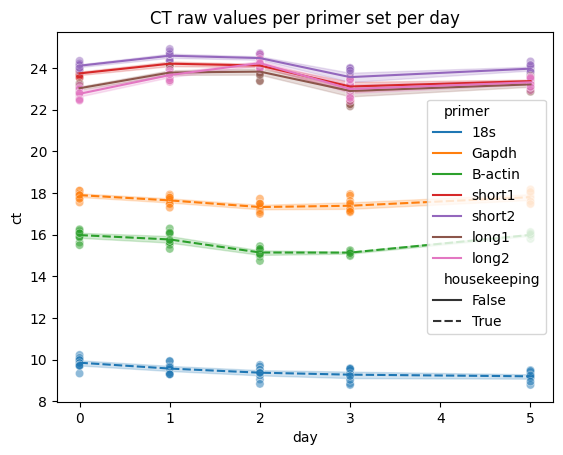

In [3]:
sns.lineplot(
    x = 'day',
    y = 'ct',
    hue = 'primer',
    style = 'housekeeping',
    legend = True,
    data = df,
)
sns.scatterplot(
    x = 'day',
    y = 'ct',
    alpha = 0.5,
    hue = 'primer',
    legend = False,
    data = df,
)
plt.title('CT raw values per primer set per day')
plt.show()
plt.close()

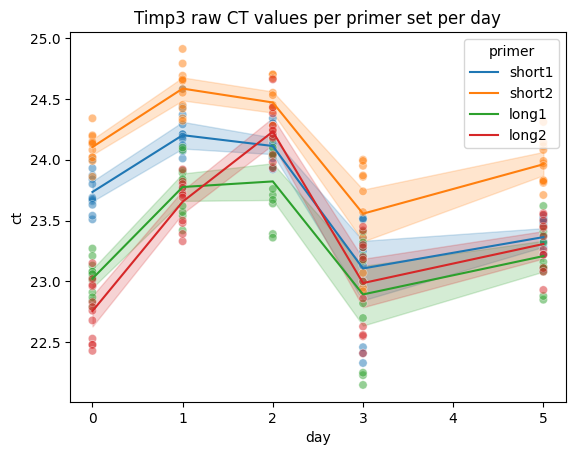

In [4]:
timp3_primers = df[~df['housekeeping']]

sns.lineplot(
    x = 'day',
    y = 'ct',
    hue = 'primer',
    legend = True,
    data = timp3_primers,
)
sns.scatterplot(
    x = 'day',
    y = 'ct',
    alpha = 0.5,
    hue = 'primer',
    legend = False,
    data = timp3_primers,
)
plt.title('Timp3 raw CT values per primer set per day')
plt.show()
plt.close()

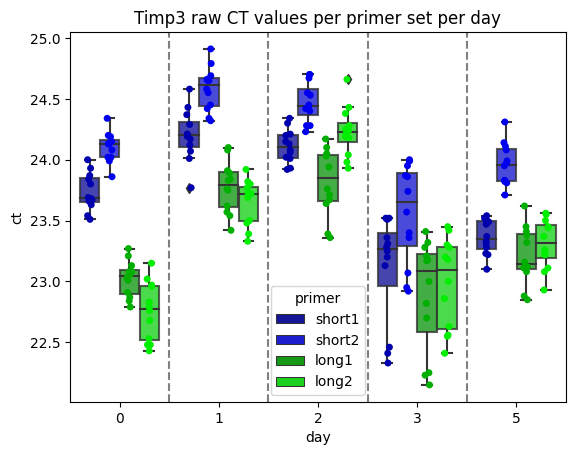

In [5]:
timp3_primers = df[~df['housekeeping']]
hue_order = ['short1','short2','long1','long2']
palette = ['#0000af','#0000ef','#00af00','#00ef00']

sns.boxplot(
    x = 'day',
    y = 'ct',
    hue = 'primer',
    hue_order = hue_order,
    palette = palette,
    boxprops = {'alpha':0.8},
    data = timp3_primers,
)
sns.stripplot(
    x = 'day',
    y = 'ct',
    hue = 'primer',
    hue_order = hue_order,
    palette = palette,
    dodge = True,
    legend = False,
    data = timp3_primers,
)

num_days = timp3_primers['day'].nunique()
for i in range(num_days-1):
    plt.axvline(i+0.5, linestyle='dashed', color='grey')

plt.title('Timp3 raw CT values per primer set per day')
plt.show()
plt.close()

In [6]:
#Calculating delta-CT of short primers using the long primers as a reference
#going to do all 4 pairwise comparisons: short1 vs long1, short2 vs long1, etc
#going to average together the techinical replicates, but keep the biological replicates separate
import itertools

timp3_primers = df[~df['housekeeping']]
long_df = timp3_primers.pivot_table(
    index = ['bio_replicate','day'],
    columns = 'primer',
    values = 'ct',
    aggfunc = 'mean',
)

sl_pairs = list(itertools.product(['short1','short2'],['long1','long2']))
delta_ct_df = pd.concat((long_df[s].subtract(long_df[l]) for s,l in sl_pairs), axis=1)
delta_ct_df.columns = (f'dCT={s}-{l}' for s,l in sl_pairs)

#Make the delta_ct_df long-form
delta_ct_df = delta_ct_df.reset_index().melt(id_vars=['bio_replicate','day'], var_name='primers', value_name='dCT')

#Calculate the fold difference between short and long
delta_ct_df['Short to Long Relative Fold Abundance'] = 2**(-delta_ct_df['dCT'])

delta_ct_df

,bio_replicate,day,primers,dCT,Short to Long Relative Fold Abundance
0,1,0,dCT=short1-long1,0.693333,0.618423
1,1,1,dCT=short1-long1,0.443333,0.735433
2,1,2,dCT=short1-long1,0.253333,0.838956
3,1,3,dCT=short1-long1,0.190000,0.876606
4,1,5,dCT=short1-long1,0.236667,0.848704
...,...,...,...,...,...
75,4,0,dCT=short2-long2,1.750000,0.297302
76,4,1,dCT=short2-long2,1.043333,0.485205
77,4,2,dCT=short2-long2,0.436667,0.738840
78,4,3,dCT=short2-long2,0.643333,0.640232


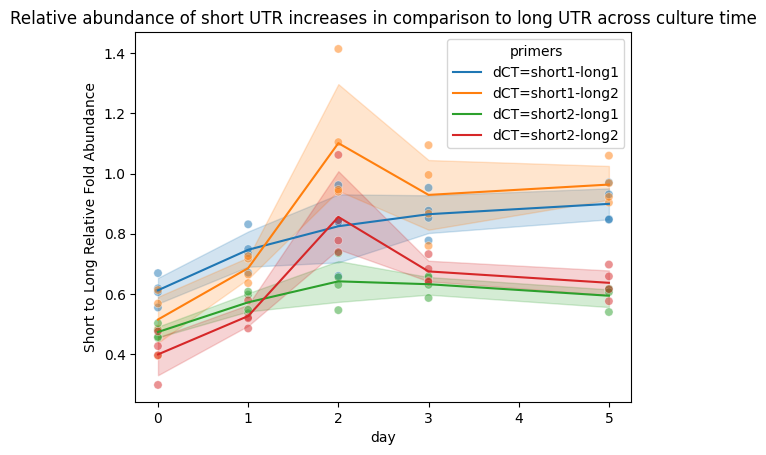

In [7]:
#plotting all combinations of the delta CTs
sns.lineplot(
    x = 'day',
    y = 'Short to Long Relative Fold Abundance',
    hue = 'primers',
    legend = True,
    data = delta_ct_df,
)
sns.scatterplot(
    x = 'day',
    y = 'Short to Long Relative Fold Abundance',
    alpha = 0.5,
    hue = 'primers',
    legend = False,
    data = delta_ct_df,
)
plt.title('Relative abundance of short UTR increases in comparison to long UTR across culture time')
plt.show()
plt.close()